# **Packages**

In [ ]:
install.packages('leaps')
library('leaps')
install.packages('car')
library('car')
install.packages('glmnet')
library('glmnet')

# **Data reading and pre-processing**

In [ ]:
dat<-read.csv(paste0("https://docs.google.com/uc?id=","1qlL1-ddLYaNhqPvyYB9_pTCXf4gAJuvx","&export=download"),header=T)

towork=as.numeric(dat$BCVA.preop)-as.numeric(dat$BCVA.6.months) #working data
age=as.numeric(dat$Age)
ivta=dat$IVTA
sex=dat$Sex
sor=NULL
pvr=NULL
for (i in 1:nrow(dat))
{
  if ((dat$SOR[i] == "done") || (dat$SOR[i]) == "Done")
    sor=c(sor,"Yes")
  else
    sor=c(sor,"No")
  if (dat$PVR[i]=="    360 degree IRC"||dat$PVR[i]=="360 degree IRC")
    pvr=c(pvr,"360 degree IRC")
  else
  {
    if (dat$PVR[i]=="PVR D3"||dat$PVR[i]=="PVRD3")
      pvr=c(pvr,"PVR D3")
    else
      pvr=c(pvr,dat$PVR[i])
  }
}
nct=as.numeric(dat$IOP)
rrd = as.numeric((dat$Complication=="Recurrent RD")) + as.numeric((dat$Complication=="Recurrent  RD")) + as.numeric((dat$Complication=="Rec RD"))

# **Non-parametric Tests of Significance and Selection Bias**

**Wilcoxon Rank Sum Test**

For testing significant decrease due to IVTA

In [ ]:
wilcox.test(towork[1:17],towork[18:35],paired = F, alternative = "less")

Warning message in wilcox.test.default(towork[1:17], towork[18:35], paired = F, :
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  towork[1:17] and towork[18:35]
W = 87.5, p-value = 0.01477
alternative hypothesis: true location shift is less than 0


**Permutation Tests** (to determine selection bias)

From Results using a C++ code,

*Age*: 
$$\text{p-value}=0.757255$$
*NCT*: 
$$\text{p-value}=0.63711$$

#**Whether PVR classification has any significance**

In [ ]:
fit = lm(towork~pvr)
anova(fit)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
pvr,3,0.7663463,0.2554488,0.3939545,0.758215
Residuals,31,20.1010823,0.6484220,NA,NA


Thus, the PVR classification has no effect on the response.

# **Modelling Response**

**Best Subset Regression**

,Abbreviation
,<chr>
ivtaYes,i
age,a
nct,n


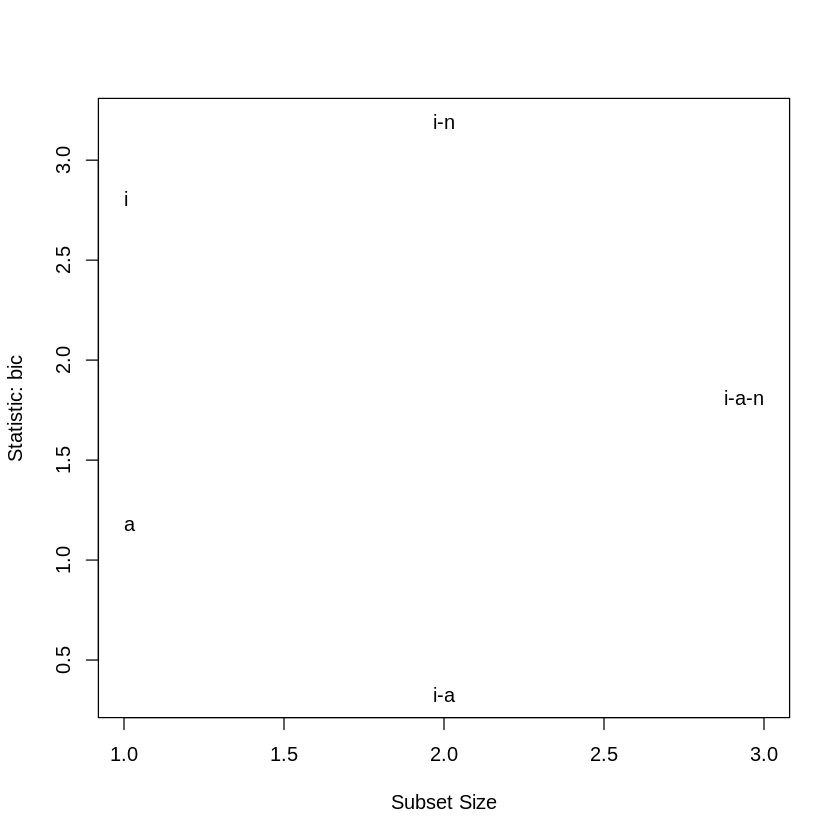

In [ ]:
mydat = data.frame(towork, ivta, age, nct)
b_mod=regsubsets(towork~.,data = mydat,nbest = 2)
#summary(b_mod)
subsets(b_mod, statistic = "bic", legend = F)

The best model is 
$$\text{Response}\sim \text{IVTA}+\text{Age}$$

We shall now proceed to find the model parameters.

**Model Fitting**

In [ ]:
fit_best = lm(towork ~ ivta + age)
summary(fit_best)


Call:
lm(formula = towork ~ ivta + age)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.2986 -0.4079 -0.1699  0.4891  1.1473 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept) 0.111203   0.261549   0.425   0.6736  
ivtaYes     0.488748   0.236081   2.070   0.0466 *
age         0.011748   0.004787   2.454   0.0197 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.6966 on 32 degrees of freedom
Multiple R-squared:  0.2558,	Adjusted R-squared:  0.2093 
F-statistic: 5.499 on 2 and 32 DF,  p-value: 0.008857


 Final model; 
 $$Response= 0.11 + (0.49\times  1_{IVTA}) + (0.01\times Age)$$

# **Dependence of RRD on IVTA**

In [ ]:
fisher.test(rrd, ivta, alternative = "two.sided")


	Fisher's Exact Test for Count Data

data:  rrd and ivta
p-value = 0.2285
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.02540224 2.30605083
sample estimates:
odds ratio 
 0.3104826 


Seems like the prevalence of RRD is unaffected by administration of IVTA. However, the data set is too small to definitely conclude something.

# **Dependence of SOR on IVTA**

In [ ]:
fisher.test(sor, ivta, alternative = "two.sided")


	Fisher's Exact Test for Count Data

data:  sor and ivta
p-value = 0.01759
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
  1.207593 38.264074
sample estimates:
odds ratio 
  6.114819 


In [ ]:
fisher.test(sor, ivta, alternative = "greater")


	Fisher's Exact Test for Count Data

data:  sor and ivta
p-value = 0.01242
alternative hypothesis: true odds ratio is greater than 1
95 percent confidence interval:
 1.49027     Inf
sample estimates:
odds ratio 
  6.114819 


At $5\%$ cut-off, SOR removal is more prevalent among those who have been administered IVTA.